In [1]:
import os 
import scipy.signal
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import lmfit
import xarray as xr
import time

import qcodes.instrument_drivers.rohde_schwarz.SGS100A as SGS100A
from pulsar_qrm.pulsar_qrm import pulsar_qrm

from quantify.data.handling import get_datadir, set_datadir
from quantify.measurement import MeasurementControl
from quantify.measurement.control import Settable, Gettable
import quantify.visualization.pyqt_plotmon as pqm
from quantify.visualization.instrument_monitor import InstrumentMonitor


In [2]:
settings = {
    "gain": 0.4,
    'data_dictionary': 'quantify-data/',

    "qc_pulse":{
        "shape": "Gaussian",
        "amplitude": 0.2,
        "freq_if": 200e6, 
        "length": 4000,
        "offset_i": 0,
        "offset_q": 0,
    },
    
    "ro_pulse":{
        "shape": "Block",
        "amplitude": 0.9,
        "freq_if": 20e6,  
        "length": 3000,
        "offset_i": -0,  
        "offset_q": -0,
    },


    "start_sample": 130,
    "hardware_avg": 1024,
    "integration_length": 2500,
    "sampling_rate": 1e9,
    "mode": "ssb",
    "software_averages": 5,
    "hardware_avg": 1024,
    
}

### Instatiate Instruments

In [3]:
LO_qrm = SGS100A.RohdeSchwarz_SGS100A("qrm_LO", 'TCPIP0::192.168.0.7::inst0::INSTR')
LO_qrm.power(15)
LO_qrm.frequency(7.79813e9-settings['ro_pulse']['freq_if'])
LO_qcm = SGS100A.RohdeSchwarz_SGS100A("qcm_LO", 'TCPIP0::192.168.0.101::inst0::INSTR')
LO_qcm.power(12)
LO_qcm.frequency(8.72e9+settings['qc_pulse']['freq_if'])

Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/113301, firmware:4.2.76.0-4.30.046.295) in 0.15s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/113300, firmware:4.2.76.0-4.30.046.295) in 0.43s


In [4]:
qrm = pulsar_qrm("qrm", "192.168.0.2")
qrm.reset()
qrm.reference_source("external")

qrm.sequencer0_gain_awg_path0(settings['gain'])
qrm.sequencer0_gain_awg_path1(settings['gain'])

#Enable hardware averaging
qrm.scope_acq_sequencer_select(0) 
qrm.scope_acq_avg_mode_en_path0(True)
qrm.scope_acq_avg_mode_en_path1(True)

qrm.scope_acq_sequencer_select(0)
qrm.scope_acq_trigger_mode_path0("sequencer")
qrm.scope_acq_trigger_mode_path1("sequencer")

#Enable sequencer sync
qrm.sequencer0_sync_en(True)

### Prepare readout and qubit control pulse waveforms

In [5]:
def prepare_waveforms(freq_if, amplitude, length, offset_i, offset_q, shape= "Block"):
    
    if shape == 'Block':
        envelope_i = amplitude*np.ones(int(length))
        envelope_q = amplitude*np.zeros(int(length))
    elif shape == 'Gaussian':
        std = length/5
        envelope_i = amplitude*scipy.signal.gaussian(length, std=std)
        envelope_q = amplitude*np.zeros(int(length))

    time = np.arange(length)*1e-9
    cosalpha = np.cos(2*np.pi*freq_if*time)
    sinalpha = np.sin(2*np.pi*freq_if*time)
    mod_matrix = np.array([[cosalpha,sinalpha],[-sinalpha,cosalpha]])
    result = []
    for it,t,ii,qq in zip(np.arange(length),time,envelope_i,envelope_q):
        result.append(mod_matrix[:,:,it]@np.array([ii,qq]))
    mod_signals = np.array(result)

    waveforms = {
            "modI_qrm": {"data": [], "index": 0},
            "modQ_qrm": {"data": [], "index": 1}
        }
    # adding mixer offsets
    waveforms["modI_qrm"]["data"] = mod_signals[:,0]+offset_i
    waveforms["modQ_qrm"]["data"] = mod_signals[:,1]+offset_q

    fig, ax = plt.subplots(1, 1, figsize=(15, 15/2/1.61))
    ax.plot(waveforms["modI_qrm"]["data"],'-',color='C0')
    ax.plot(waveforms["modQ_qrm"]["data"],'-',color='C1')
    ax.title.set_text('Pulse')
    return waveforms

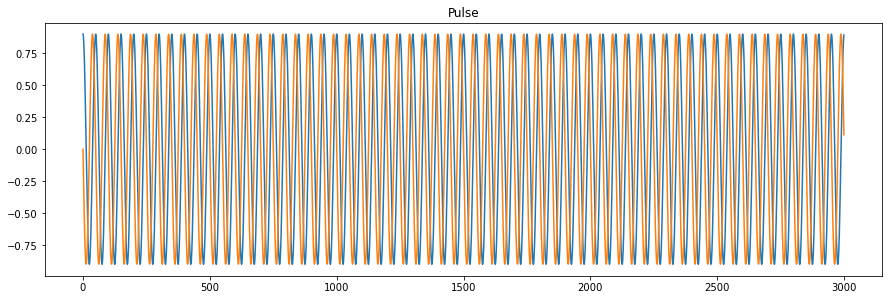

In [6]:
ro_pulse_waveforms=prepare_waveforms(freq_if = settings["ro_pulse"]["freq_if"], amplitude = settings["ro_pulse"]["amplitude"], length = settings["ro_pulse"]["length"], 
                                offset_i = settings["ro_pulse"]["offset_i"], offset_q = settings["ro_pulse"]["offset_q"], shape= settings["ro_pulse"]["shape"])

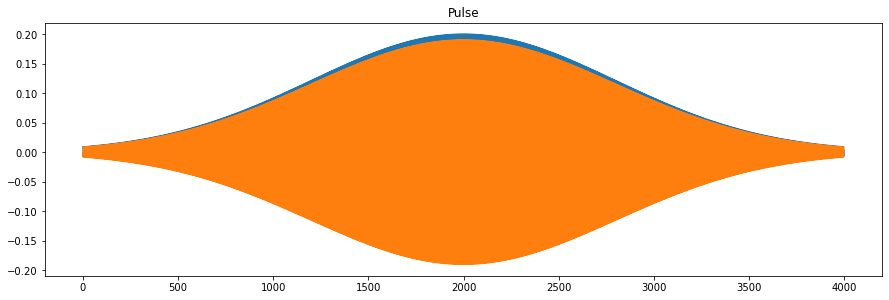

In [7]:
qc_pulse_waveforms=prepare_waveforms(freq_if = settings["qc_pulse"]["freq_if"], amplitude = settings["qc_pulse"]["amplitude"], length = settings["qc_pulse"]["length"], 
                                offset_i = settings["qc_pulse"]["offset_i"], offset_q = settings["qc_pulse"]["offset_q"], shape= settings["qc_pulse"]["shape"])

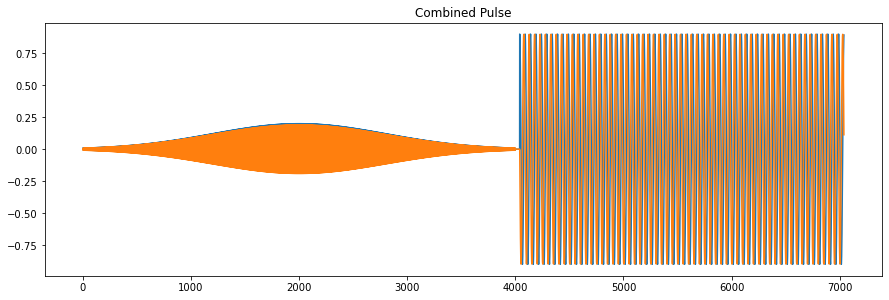

In [9]:
combined_waveforms = {
            "modI_qrm": {"data": [], "index": 0},
            "modQ_qrm": {"data": [], "index": 1}
        }
combined_waveforms["modI_qrm"]["data"] = np.concatenate((qc_pulse_waveforms["modI_qrm"]["data"],np.zeros(40), ro_pulse_waveforms["modI_qrm"]["data"]))
combined_waveforms["modQ_qrm"]["data"] = np.concatenate((qc_pulse_waveforms["modQ_qrm"]["data"],np.zeros(40), ro_pulse_waveforms["modQ_qrm"]["data"]))


fig, ax = plt.subplots(1, 1, figsize=(15, 15/2/1.61))
ax.plot(combined_waveforms["modI_qrm"]["data"],'-',color='C0')
ax.plot(combined_waveforms["modQ_qrm"]["data"],'-',color='C1')
ax.title.set_text('Combined Pulse')

### Prepare readout and qubit control sequence programs

In [ ]:
def calculate_repetition_rate(repetition_duration,
                              wait_loop_step,
                              duration_base):
    extra_duration = repetition_duration-duration_base
    extra_wait = extra_duration%wait_loop_step
    num_wait_loops = (extra_duration-extra_wait)//wait_loop_step
    return num_wait_loops,extra_wait

In [ ]:
acquisitions = {"single":   {"num_bins": 1,"index":0}}

repetition_duration= 200000
wait_loop_step=1000
duration_base=16380

buffer_time = 40  #ns
num_wait_loops,extra_wait = calculate_repetition_rate(repetition_duration, wait_loop_step, duration_base)

seq_prog = f"""
    move    {settings["hardware_avg"]},R0
    nop
    wait_sync 4                               # Synchronize sequencers over multiple instruments

loop:
    play      0,1,{settings["qc_pulse"]["length"]+buffer_time+4}      # Play waveforms (0,1) in channels (O0,O1) and wait settings["qc_pulse"]["length"]+ buffer_time + 4 ns.
    acquire   0,0,4                           # Acquire waveforms over remaining duration of acquisition of input vector of length = 16380 with integration weights 0,0
    wait      {duration_base-4-settings["qc_pulse"]["length"]-buffer_time}
    move      {num_wait_loops},R1     # repetion rate loop iterator
    nop
    reprateloop:
        wait      {wait_loop_step}
        loop      R1,@reprateloop
    wait      {extra_wait}
    loop    R0,@loop

    stop
"""

print(seq_prog)

### Upload waveforms

In [ ]:
# Reformat waveforms to lists.
for name in combined_waveforms:
    if str(type(combined_waveforms[name]["data"]).__name__) == "ndarray":
        combined_waveforms[name]["data"] = combined_waveforms[name]["data"].tolist()  # JSON only supports lists

In [ ]:
#Add sequence program and waveforms to single dictionary and write to JSON file.
wave_and_prog_dict = {"waveforms": combined_waveforms, "weights":{}, "acquisitions": acquisitions, "program": seq_prog}
with open("qrm_alone_sequence.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()

In [ ]:
#Upload waveforms and program.
qrm.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "qrm_alone_sequence.json"))

In [ ]:
print("QRM status:")
print(qrm.get_sequencer_state(0))
print()

print("QRM snapshot:")
qrm.print_readable_snapshot(update=True)

In [ ]:
class gettable_qrm_controller():
    # Quantify Gettable Interface Implementation
    label = ['Amplitude', 'Phase','I','Q']
    unit = ['V', 'Radians','V','V']
    name = ['A', 'Phi','I','Q']
    
    def __init__(self, qrm, settings):
        self._qrm = qrm
        self._settings = settings
    
    def get(self):
        return self.run()
    
    def run(self):
        qrm = self._qrm
        sequencer = 0
        #arm sequencer and start playing sequence
        qrm.arm_sequencer()
        qrm.start_sequencer()
        #start acquisition of data
        #Wait for the sequencer to stop with a timeout period of one minute.
        qrm.get_sequencer_state(0, 1)
        #Wait for the acquisition to finish with a timeout period of one second.
        qrm.get_acquisition_state(sequencer, 1)
        #Move acquisition data from temporary memory to acquisition list.
        qrm.store_scope_acquisition(sequencer, "single")
        #Get acquisition list from instrument.
        self._single_acq = qrm.get_acquisitions(sequencer)
        i,q = self._demodulate_and_integrate()
        acquisition_results = np.sqrt(i**2+q**2),np.arctan2(q,i),i,q
        self._acquisition_results = acquisition_results
        return acquisition_results

    def _demodulate_and_integrate(self):
        settings = self._settings
        freq_if = settings['ro_pulse']['freq_if']
        start_sample =   settings['start_sample']
        integration_length = settings['integration_length']
        sampling_rate = settings['sampling_rate']
        mode = settings['mode']

        #DOWN Conversion
        norm_factor = 1./(integration_length)
        input_vec_I = np.array(self._single_acq["single"]["acquisition"]["scope"]["path0"]["data"][start_sample:start_sample+integration_length])
        input_vec_Q = np.array(self._single_acq["single"]["acquisition"]["scope"]["path1"]["data"][start_sample:start_sample+integration_length])
        input_vec_I -= np.mean(input_vec_I)
        input_vec_Q -= np.mean(input_vec_Q)

        if mode == 'ssb':
            modulated_i = input_vec_I
            modulated_q = input_vec_Q
            time = np.arange(modulated_i.shape[0])*1e-9
            cosalpha = np.cos(2*np.pi*freq_if*time)
            sinalpha = np.sin(2*np.pi*freq_if*time)
            demod_matrix = 2*np.array([[cosalpha,-sinalpha],[sinalpha,cosalpha]])
            result = []
            for it,t,ii,qq in zip(np.arange(modulated_i.shape[0]),time,modulated_i,modulated_q):
                result.append(demod_matrix[:,:,it]@np.array([ii,qq]))
            demodulated_signal = np.array(result)
            integrated_signal = norm_factor*np.sum(demodulated_signal,axis=0)
        elif mode == 'optimal':
            raise NotImplementedError('Optimal Demodulation Mode not coded yet.')
        else:
            raise NotImplementedError('Demodulation mode not understood.')

        self.integrated_signal = integrated_signal
        self.demodulated_signal = demodulated_signal.tolist()

        return integrated_signal


In [ ]:
MC = MeasurementControl('MC')
plotmon = pqm.PlotMonitor_pyqt('plotmon')
insmon = InstrumentMonitor("Instruments Monitor")

MC.instr_plotmon(plotmon.name)
MC.instrument_monitor(insmon.name)

In [ ]:
set_datadir(settings['data_dictionary'])
print(f"Data will be saved in:\n{get_datadir()}")

In [ ]:
soft_avg_numnber = 2

### Resonator

In [ ]:
LO_qrm.on()
LO_qcm.off()

lowres_width = 30e6
lowres_step = 2e6
highres_width = 0.5e6
highres_step = 0.05e6
scanrange = np.concatenate((np.arange(-lowres_width,-highres_width,lowres_step),np.arange(-highres_width,highres_width,highres_step),np.arange(highres_width,lowres_width,lowres_step)))

MC.settables(LO_qrm.frequency)
MC.setpoints(scanrange + 7.7981e9-settings["ro_pulse"]["freq_if"])
MC.gettables(Gettable(gettable_qrm_controller(qrm,settings)))

dataset = MC.run('Resonator Spectroscopy', soft_avg = soft_avg_numnber)

LO_qrm.off()

### Qubit

In [ ]:
LO_qrm.frequency(7.79805e9-settings['ro_pulse']['freq_if'])

In [ ]:
LO_qcm.on()
LO_qrm.on()

lowres_width = 30e6
lowres_step = 2e6
highres_width = 5e6
highres_step = 0.2e6
scanrange = np.concatenate((np.arange(-lowres_width,-highres_width,lowres_step),np.arange(-highres_width,highres_width,highres_step),np.arange(highres_width,lowres_width,lowres_step)))

MC.settables(LO_qcm.frequency)
MC.setpoints(scanrange + 8.724e9+settings["qc_pulse"]["freq_if"])
MC.gettables(Gettable(gettable_qrm_controller(qrm,settings)))

dataset = MC.run('Qubit Spectroscopy', soft_avg = soft_avg_numnber)

LO_qcm.off()
LO_qrm.off()

In [ ]:
qrm.stop()
qcm.stop()
LO_qcm.off()
LO_qrm.off()
LO_qrm.close()
LO_qcm.close()